In [1]:
include("../src/GaPSE.jl");

In [2]:
FILE_F_MAP = "../data/F_REFERENCE.txt"
FILE_PS = "../data/WideA_ZA_pk.dat"
FILE_BACKGROUND = "../data/WideA_ZA_background.dat"

z_min = 0.05
z_max = 0.20
θ_max = π / 2.0
params = GaPSE.CosmoParams(z_min, z_max, θ_max;
  k_min = 1e-8, k_max = 10.0,
  Ω_b = 0.0489, Ω_cdm = 0.251020, h_0 = 0.70)
cosmo = GaPSE.Cosmology(params, FILE_BACKGROUND, FILE_PS, FILE_F_MAP)

GaPSE.parameters_used(stdout, cosmo)

# The following parameters were used for this computation: 
# CLASS Power Spectrum input file : "../data/WideA_ZA_pk.dat"
# F window function input file : "../data/F_REFERENCE.txt"
# CLASS Background input file: "../data/WideA_ZA_background.dat"
# 	 z_min = 0.05 	 z_max = 0.2
# 	 k_min = 1.0e-8 	 k_max = 10.0
# 	 h_0 = 0.7 	 Ω_b = 0.0489 	 Ω_cdm = 0.25102 	 Ω_M0 = 0.29992
# 	 comoving s_min = 148.1920001343431 Mpc/h_0
# 	 comoving s_max = 571.7022420911966 Mpc/h_0
# 	 comoving s_eff = 435.37470960794167 Mpc/h_0
# 	 comoving z_eff = 0.15045636097417317 
# 	 Volume of the survey V_survey = 3.845366169354268e8
# 	 σ_0 = 18.584280735797098
# 	 σ_1 = 15.75556280411702
# 	 σ_2 = 101.0636221421908
# 	 σ_3 = 18.584280735797098
# 


In [3]:
using Trapz, Plots, LegendrePolynomials

In [4]:
function ξ_lensing(s1, s2, y, cosmo::GaPSE.Cosmology; 
        NN = 10, enhancer = 1, Δχ_min = 1)
    adim_χs = range(0.0, 1.0, NN)
    
    P1, P2 = GaPSE.Point(s1, cosmo), GaPSE.Point(s2, cosmo)
    χ1s = adim_χs .* s1
    χ2s = adim_χs .* s2
    
    IP1s = [GaPSE.Point(x, cosmo) for x in χ1s]
    IP2s = [GaPSE.Point(x, cosmo) for x in χ2s]
    
    int_ξ_lensings = [
        GaPSE.integrand_ξ_lensing(IP1, IP2, P1, P2, y, cosmo; 
            enhancer = enhancer, Δχ_min = Δχ_min)
         for IP1 in IP1s, IP2 in IP2s
    ]
    
    #a = [0.0, 0.0]
    #b = [s1, s2]
    #int = hcubature(my_int, a, b; kwargs...)
    #println(int)
    return trapz((χ1s, χ2s), int_ξ_lensings)
end

ξ_lensing (generic function with 1 method)

In [5]:
function integrand_on_mu_lensing(s1, s, μ, cosmo::GaPSE.Cosmology;
     L::Integer = 0,
     use_windows::Bool = true,
        kwargs...
 )

    s2_value = GaPSE.s2(s1, s, μ)
    y_value = GaPSE.y(s1, s, μ)
    if use_windows == true
        ϕ_s2 = GaPSE.ϕ(s2_value)
        (ϕ_s2 > 0.0) || (return 0.0)
        #println("s1 = $s1 \t s2 = $(s2(s1, s, μ)) \t  y=$(y(s1, s, μ))")
        int = ξ_lensing(s1, s2_value, y_value, cosmo; kwargs...)
        #println("int = $int")
        return int .* (ϕ_s2 * GaPSE.spline_F(s / s1, μ, cosmo.windowF) * Pl(μ, L))
    else
        #println("s1 = $s1 \t s2 = $(s2(s1, s, μ)) \t  y=$(y(s1, s, μ))")
        int = ξ_lensing(s1, s2_value, y_value, cosmo; kwargs...)
        #println("int = $int")
        return int .* Pl(μ, L)
    end
end

integrand_on_mu_lensing (generic function with 1 method)

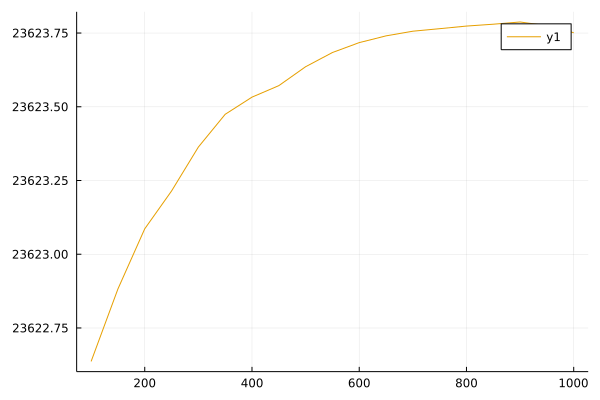

In [6]:
xs = range(100, 1000; step=50)
ys = [ξ_lensing(cosmo.s_eff, 500, 0.99, cosmo; NN = n, enhancer = 1e12, Δχ_min = 1e-6)
            for n in xs]
plot(xs, ys)

In [11]:
function my_integral_on_mu(s1, s, integrand, cosmo::GaPSE.Cosmology;
        L::Integer = 0,
        enhancer::Float64 = 1e6,
        use_windows::Bool = true,
        #μ_atol::Float64 = 1e-3,
        #μ_rtol::Float64 = 1e-3,
        Numb=10,
        kwargs...
        )
    
    

    μs1 = range(-1.0,-0.9, length=Numb)
    μs2 = range(-0.9, 0.9, length=Numb)
    μs3 = range(0.9, 1.0, length=Numb)
    μs = unique(vcat(μs1, μs2, μs3))
    fs = [integrand(s1, s, μ, cosmo; enhancer = enhancer, L = L,
        use_windows = use_windows, kwargs...) for μ in μs ]
    
    

    #println("s1 = $s1 \t s = $s")
    #int = quadgk(μ -> f(μ), -1.0, 1.0; rtol = μ_rtol, atol = μ_atol)
    #println("s1 = $s1 \t s2 = $s \t int = $int")
    return trapz(μs,fs) / enhancer
end

my_integral_on_mu (generic function with 1 method)

In [9]:
function integral_on_mu(s1, s, integrand::Function, cosmo::GaPSE.Cosmology;
     L::Integer = 0,
     enhancer::Float64 = 1e6,
     use_windows::Bool = true,
     μ_atol::Float64 = 1e-3,
     μ_rtol::Float64 = 1e-3,
     kwargs...
)

     f(μ) = integrand(s1, s, μ, cosmo; enhancer = enhancer, L = L,
          use_windows = use_windows, kwargs...)[1]

     #println("s1 = $s1 \t s = $s")
     int = quadgk(μ -> f(μ), -1.0, 1.0; rtol = μ_rtol, atol = μ_atol)
     #println("s1 = $s1 \t s2 = $s \t int = $int")
     return int ./ enhancer
end

integral_on_mu (generic function with 2 methods)

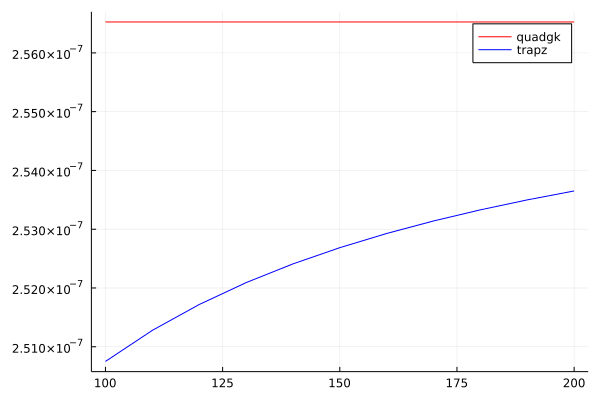

In [14]:
s = 15
Δχ_min = 1e-5
NN = 100
xs = range(100, 200; step=10)

val = integral_on_mu(cosmo.s_eff, s, integrand_on_mu_lensing, cosmo; 
         L=0, use_windows = false, enhancer = 1e12, Δχ_min=Δχ_min, 
            NN = NN)[1]
ys_1 = [val for x in xs]

ys_2 = [my_integral_on_mu(cosmo.s_eff, s, integrand_on_mu_lensing, cosmo; 
        Numb=x, L=0, use_windows = false, enhancer = 1e12, Δχ_min=Δχ_min, 
    NN = NN)
        for x in xs]

plot([xs xs],  [ys_1, ys_2], legend=:topright, label=["quadgk" "trapz"],
        lc=[:red :blue])

In [15]:
@time integral_on_mu(cosmo.s_eff, s, integrand_on_mu_lensing, cosmo; 
         L=0, use_windows = false, enhancer = 1e12, Δχ_min=Δχ_min, 
            NN = 500)

 28.884132 seconds (932 allocations: 206.326 MiB, 0.08% gc time)


(2.5651871542924085e-7, 2.481833249750489e-10)

In [18]:
@time my_integral_on_mu(cosmo.s_eff, s, integrand_on_mu_lensing, cosmo; 
        Numb=30, L=0, use_windows = false, enhancer = 1e12, Δχ_min=Δχ_min, 
    NN = 500)

 22.559917 seconds (730 allocations: 172.926 MiB, 0.10% gc time)


2.5255261820613356e-7